In [1]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np   
import pandas as pd
import scipy
import sklearn.model_selection
import sklearn.neighbors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)                          # Annoying
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
import time
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Reading Data and Feature Extraction

In [2]:
data= pd.read_csv('COMP6321-ML-Project-main/dataset.CSV')
y= data['Speaker'].to_numpy()
all_data = data.to_numpy()
## we will take 60/40 training testing ratio
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_data[:,2:], y,
                                                                            test_size=0.4, random_state=10)
#Input Normalization
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

#In this following we splitted the MFCC features and MFCC-Delta Features
MFCC_train= X_train[:,:13]
MFCC_Delta_train= X_train[:,13:]
MFCC_test= X_test[:,:13]
MFCC_Delta_test= X_test[:,13:]

# 2D Visualization of training data

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 570 samples in 0.002s...
[t-SNE] Computed neighbors for 570 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 570 / 570
[t-SNE] Mean sigma: 1.560074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.117992
[t-SNE] KL divergence after 500 iterations: 0.266670


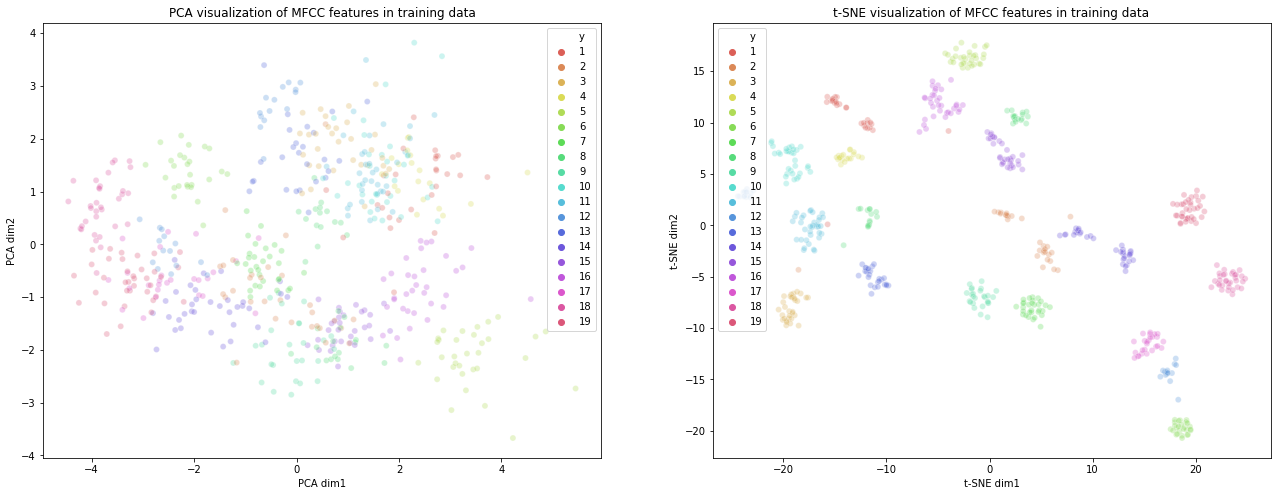

In [3]:
# The original data set is 13 dimension, for visualization, it should be reduced in two dimensions
# we prefer to feed the data in a DataFrame and then use the seaborn library to show the data for 2D visualization

feat_cols = [ str(i) for i in range(MFCC_train.shape[1]) ] 
df = pd.DataFrame(MFCC_train,columns=feat_cols)
df['y'] = y_train

twoD= sklearn.decomposition.PCA(n_components= 2).fit_transform(MFCC_train) #2D reduce dimension using PCA
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500).fit_transform(MFCC_train);#2D reduce dimension using t-SNE

plt.figure(figsize=(22,8))
ax1 = plt.subplot(1, 2, 1)
ax1= sns.scatterplot(
    x=twoD[:,0], y=twoD[:,1],
    hue="y",
    palette=sns.color_palette("hls", 19),
    data=df,
    legend="full",
    alpha=0.3
)
ax1.set(xlabel="PCA dim1", ylabel = "PCA dim2")
ax1.set_title('PCA visualization of MFCC features in training data')

ax2 = plt.subplot(1, 2, 2)
ax2= sns.scatterplot(
    x=tsne[:,0], y=tsne[:,1],
    hue="y",
    palette=sns.color_palette("hls", 19),
    data=df,
    legend="full",
    alpha=0.3
)
ax2.set(xlabel="t-SNE dim1", ylabel = "t-SNE dim2")
ax2.set_title('t-SNE visualization of MFCC features in training data');

# 3D Visualization of training data (Only PCA)

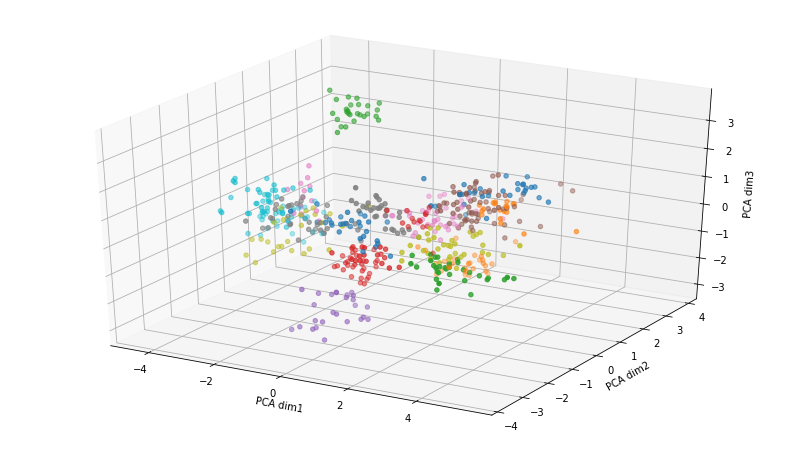

In [4]:
tD= sklearn.decomposition.PCA(n_components= 3).fit_transform(MFCC_train)

ax = plt.figure(figsize=(14,8)).gca(projection='3d')
ax.scatter(xs=tD[:,0], ys=tD[:,1], zs=tD[:,2], c=y_train, cmap='tab10')
ax.set_xlabel('PCA dim1')
ax.set_ylabel('PCA dim2')
ax.set_zlabel('PCA dim3')
plt.show()

# Classification Methods

## K nearest Neighborhood

As follows we apply the K nearest neighborhood for the MFCC data (and then for MFCC delta features), The hyperparameter in this classification are weights and k that can be changed in range of [1,40]. By considering the training and testing error, the best value for hyperparameter would be chosen.
(We prefered to use the GridSearch hyerperarameter search for knn).
Moreover, we use a 10 folded validation to ensure consistent distribution of classes in the training and testing phase and to also ensure that our model does not overfit for a particular split.

In [30]:
def KNN(xtrn, xtst, ytrn, ytst, **kwargs):
    '''
    In this function the best K-Nearest-Neighborhood is found and applied using GridSearch. 
    The outpout is training and test accuracy the best model.
    '''
    param_KNN={'n_neighbors':[1, 5, 10, 13, 15, 20, 25, 30, 40], 'weights':['uniform', 'distance']} 
    KNN= sklearn.neighbors.KNeighborsClassifier()
    GridSearch= sklearn.model_selection.GridSearchCV(KNN,param_KNN, cv=10, **kwargs).fit(xtrn, ytrn); 
    KNN_Score= GridSearch.best_score_*100
    print("The best score is: %.2f" %KNN_Score)
    print("The best patameters is:", GridSearch.best_params_)

    GStrain=GridSearch.best_estimator_.score(xtrn, ytrn)*100
    GStest= GridSearch.best_estimator_.score(xtst, ytst)*100
    return GStest, GridSearch.best_estimator_

In [72]:
def performance(model,xtrn, xtst, ytrn, ytst):
    '''
    In this function the confusion matrix and scores are printed.
    '''
    # Training and testing Scores
    train=model.score(xtrn, ytrn)*100
    test= model.score(xtst, ytst)*100
    print('%.1f%% train accuracy' %train)
    print('%.1f%% test accuracy' %test)
    #F1 Score
    model_F1_metric= sklearn.metrics.f1_score(ytst, model.predict(xtst), average='macro')
    print('model_F1_metric:', model_F1_metric)

    #Confusion Matrix
    fig, ax = plt.subplots(figsize=(8,8))
    sklearn.metrics.plot_confusion_matrix(model, xtst,ytst, ax=ax)
    plt.show()

### Training KNN on MFCC and MFCC_ delta features

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.6s finished


The best score is: 99.12
The best patameters is: {'n_neighbors': 1, 'weights': 'uniform'}
Randomized search:
100.0% train accuracy
99.7% test accuracy
model_F1_metric: 0.997353534685236


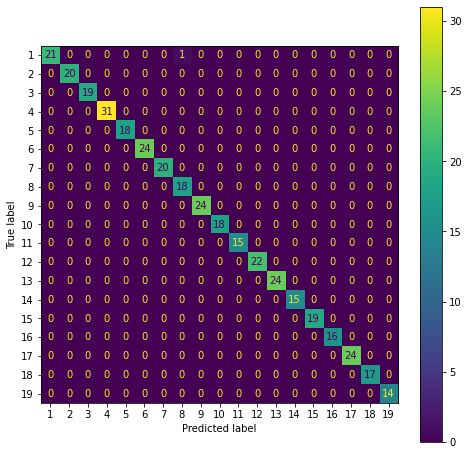

In [32]:
_, model=KNN(MFCC_train, MFCC_test,y_train , y_test, verbose=1) #MFCC features
performance(model, MFCC_train, MFCC_test,y_train , y_test)

The MFCC delta features are 26 features, first we find the best fitted between fewer dimensions, then, compare with the original features.

In [58]:
# In this cell KNN is applied to the reduced dimension of X_train into different dimensions to see which one has
#the best accuracy
score=[]
for i in range(1,26):
    PCA= sklearn.decomposition.PCA(n_components= i).fit(X_train)
    PCA_train= PCA.transform(X_train)
    PCA_test= PCA.transform(X_test)
    test_score, _= KNN(PCA_train, PCA_test, y_train, y_test);
    score.append(test_score)
print('\033[94m',"Best Dimension is", score.index(max(score)), 'the max accuracy is', max(score), '\033[0m')

The best score is: 36.84
The best patameters is: {'n_neighbors': 30, 'weights': 'uniform'}
The best score is: 39.82
The best patameters is: {'n_neighbors': 40, 'weights': 'uniform'}
The best score is: 57.37
The best patameters is: {'n_neighbors': 25, 'weights': 'distance'}
The best score is: 64.39
The best patameters is: {'n_neighbors': 20, 'weights': 'distance'}
The best score is: 66.49
The best patameters is: {'n_neighbors': 5, 'weights': 'distance'}
The best score is: 77.72
The best patameters is: {'n_neighbors': 10, 'weights': 'distance'}
The best score is: 83.51
The best patameters is: {'n_neighbors': 10, 'weights': 'distance'}
The best score is: 81.75
The best patameters is: {'n_neighbors': 10, 'weights': 'distance'}
The best score is: 83.16
The best patameters is: {'n_neighbors': 5, 'weights': 'uniform'}
The best score is: 82.98
The best patameters is: {'n_neighbors': 10, 'weights': 'distance'}
The best score is: 85.26
The best patameters is: {'n_neighbors': 13, 'weights': 'dist

So the best Component in term of accuracy is 23.

In [66]:
# Comparison 26 and 23 dimensions
test, _=KNN(X_train, X_test, y_train , y_test, verbose=1) #MFCC delta features are 26 feautures includes the MFCC ones 
print('\033[95m', 'MFCC delta features have: %0.2f%% accuracy' % test, '\033[0m')

PCA= sklearn.decomposition.PCA(n_components= 23).fit(X_train)
PCA_train= PCA.transform(X_train)
PCA_test= PCA.transform(X_test)
PCAaccuracy, _=KNN(PCA_train, PCA_test, y_train, y_test, verbose=1)
print('\033[95m','PCA reduced features have: %0.2f%% accuracy' % PCAaccuracy, '\033[0m')

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best score is: 96.32
The best patameters is: {'n_neighbors': 5, 'weights': 'distance'}
 MFCC delta features have: 97.11% accuracy 
Fitting 10 folds for each of 18 candidates, totalling 180 fits
The best score is: 96.14
The best patameters is: {'n_neighbors': 10, 'weights': 'distance'}
 PCA reduced features have: 96.58% accuracy 


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.8s finished


## Support Vector Machine
In this Classification, two methods of OnevsRest and crammer_singer are applied for multiclass classification. The hyperparameter is C which is changed from log1= 0 to log100=2. The search for the best hyperparameter is randomized.

In [67]:
np.random.seed(0)

def SVM(xtrn, xtst, ytrn, ytst, **kwargs):
    '''
    In this function the best Linear SVC is found and applied on the data
    using RandomizedSearch. The outpout is test accuracy and best fitted model.
    '''
    SVC= sklearn.svm.LinearSVC(**kwargs)
    param_SVM= {'C':scipy.stats.reciprocal(1, 100)}
    SVM_search= sklearn.model_selection.RandomizedSearchCV(SVC, param_SVM,
                                                               random_state=0, verbose=1, n_iter=20, cv=10)
    SVM_search.fit(xtrn, ytrn);

    SVC_Score= SVM_search.best_score_*100
    print("The best score is: %.2f" %SVC_Score)
    print("The best patameters is:", SVM_search.best_params_)

    # Testing Scores
    SVCtest= SVM_search.best_estimator_.score(xtst, ytst)*100
    return SVCtest, SVM_search.best_estimator_

### Training SVM on MFCC and MFCC_ delta features

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.2s finished


The best score is: 99.12
The best patameters is: {'C': 12.520653814999461}
Randomized search:
100.0% train accuracy
97.9% test accuracy
model_F1_metric: 0.9790766477612541


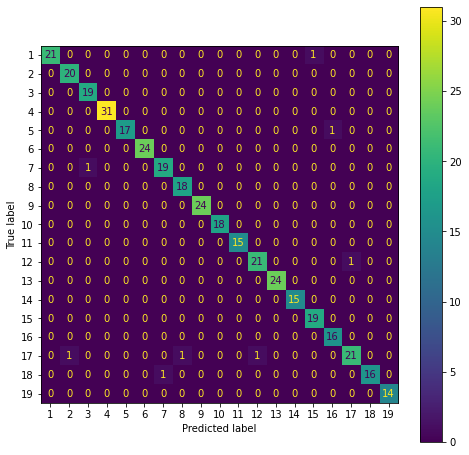

In [68]:
_, SVMmodel= SVM(MFCC_train, MFCC_test,y_train , y_test, multi_class='crammer_singer') #MFCC
performance(SVMmodel, MFCC_train, MFCC_test,y_train , y_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.3s finished


The best score is: 98.07
The best patameters is: {'C': 5.846326121643412}
Randomized search:
99.6% train accuracy
97.6% test accuracy
model_F1_metric: 0.9743080810802953


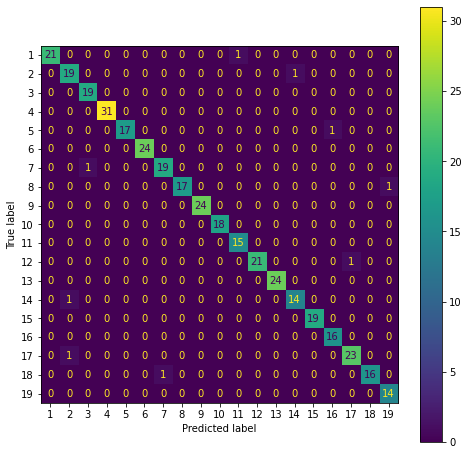

In [69]:
_, SVMmodel= SVM(MFCC_train, MFCC_test,y_train , y_test, multi_class='ovr')
performance(SVMmodel, MFCC_train, MFCC_test,y_train , y_test)

OvR seems better estimator, as it is faster and its testing accuracy is not much less than 'crammer_singer' so choose this one.
Rely on Previous part and choose 23 dimensions

In [71]:
test, _= SVM(X_train, X_test,y_train , y_test, multi_class='ovr') # MFCC delta
print('\033[95m', 'MFCC delta features have: %0.2f%% accuracy' % test, '\033[0m')

PCA_accuracy, _= SVM(PCA_train, PCA_test,y_train , y_test, multi_class='ovr') #23 dimension
print('\033[95m','PCA reduced features have: %0.2f%% accuracy' % PCA_accuracy, '\033[0m')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best score is: 96.49
The best patameters is: {'C': 1.0975815419380157}
 MFCC delta features have: 97.11% accuracy 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
The best score is: 93.68
The best patameters is: {'C': 1.0975815419380157}
 PCA reduced features have: 95.00% accuracy 


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.7s finished
